In [1]:
# Read our file of songs
# Read our CSV with ground truth
# Order songs based on our algortihm
# Compare optimized order to original order
# For each file of songs: Plot the error between predicted bpm and key and true bpm and key 

In [2]:
import sys
import os
sys.path.append('..')
print(os.getcwd())

from src.utilities.BPM import BPM_extractor
from src.utilities.predictKey import predict_key
from src.utilities.transition_cost import bpm_diff, key_diff, transition_cost
from src.utilities.playlist_optimizer import create_path_from_df

import  matplotlib.pyplot as plt 
from pydub import AudioSegment
import numpy as np 
import librosa
import pandas as pd
import os 

/Users/jarlstephansson/Desktop/DT2470 Music/Project/notebooks


In [3]:

def get_sound(path):
    sound = AudioSegment.from_file(path)
    fs = sound.frame_rate
    if sound.channels == 2:
        sound = sound.set_channels(1)
    # normalize 
    audio = np.array(sound.get_array_of_samples())
    audio = audio / np.max(np.abs(audio))
    return audio, fs

In [4]:
def get_predictions(map_path, data_path, novelty, tempogram): 
    df = pd.read_csv(map_path)
    key_preds = []
    bpm_preds = []

    for i, row in df.iterrows():
        file_path = os.path.join(data_path, f"{row['name']}.mp3")
        audio, fs = get_sound(file_path)
        
        Extractor = BPM_extractor(
            fs,
            novelty=novelty,
            tempogram=tempogram,
            tempo_w=30, 
            tempo_hop=3, 
            novelty_w = 5.0, 
            novelty_hop= 0.05
        )
        bpm = Extractor.get_BPM(audio, plot=False)
        bpm_preds.append(bpm)
        key=predict_key(file_path)
        key_preds.append(key)

    return bpm_preds, key_preds


Print true bpms and Keys with predicted bpms and Keys

In [5]:
map_path = "../data/590.csv"
data_path = "../data/David Guetta Playlist 590"
bpm_preds, keys_preds = get_predictions(map_path, data_path, "spectral", "fourier")

df_extended = pd.read_csv(map_path)
df_extended["predicted_bpm"] = bpm_preds
df_extended["predicted_key"] = keys_preds

df_extended.head(50)

,name,bpm,key,ix,predicted_bpm,predicted_key
0,Bassline (feat. The Get Along Gang) - Ruben La...,124,6A,13,124.002596,3B
1,Bits And Pieces - Matt Smallwood Remix,128,4A,15,128.011924,4A
2,Domino (feat. Oxia),126,2A,6,126.072096,2A
3,Dreams (feat. Lanie Gardner) - Extended,128,8A,5,128.160265,8A
4,Friends - Main Mix,126,1A,2,126.540527,10A
5,Higher Love (feat. Nuala),125,9A,12,125.080423,9A
6,Love Me Better - Extended Mix,124,8A,7,124.404098,8A
7,Love Tonight (David Guetta Remix),126,5A,3,157.130859,5A
8,Pepas - David Guetta Remix,127,8A,4,127.168157,9A
9,Runaway,125,5A,8,125.939941,5A


In [6]:
test_df = pd.read_csv(map_path)
tesst_df=test_df.sort_values(by="ix")
tesst_df.head(20)

,name,bpm,key,ix
13,Titanium (feat. Sia) - David Guetta & MORTEN F...,126,5A,1
4,Friends - Main Mix,126,1A,2
7,Love Tonight (David Guetta Remix),126,5A,3
8,Pepas - David Guetta Remix,127,8A,4
3,Dreams (feat. Lanie Gardner) - Extended,128,8A,5
2,Domino (feat. Oxia),126,2A,6
6,Love Me Better - Extended Mix,124,8A,7
9,Runaway,125,5A,8
10,The Music - Kideko Remix,126,6A,9
12,This Sound,126,6A,10


Plot BPM and Key prediction error based on transition cost functions

Average normalized bpm error: 0.06084845330601701
Average normalized key error: 0.12380952380952381


/var/folders/sb/32vq3zzd7cz67vrg4tz_4ymm0000gn/T/ipykernel_69082/2084301499.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


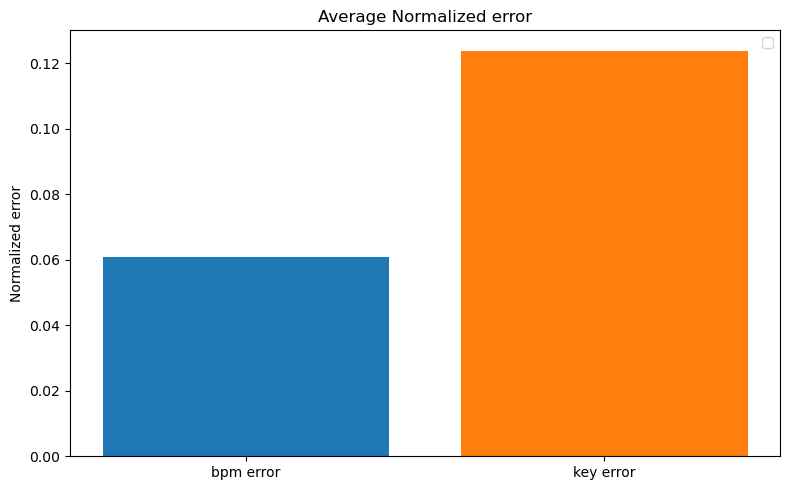

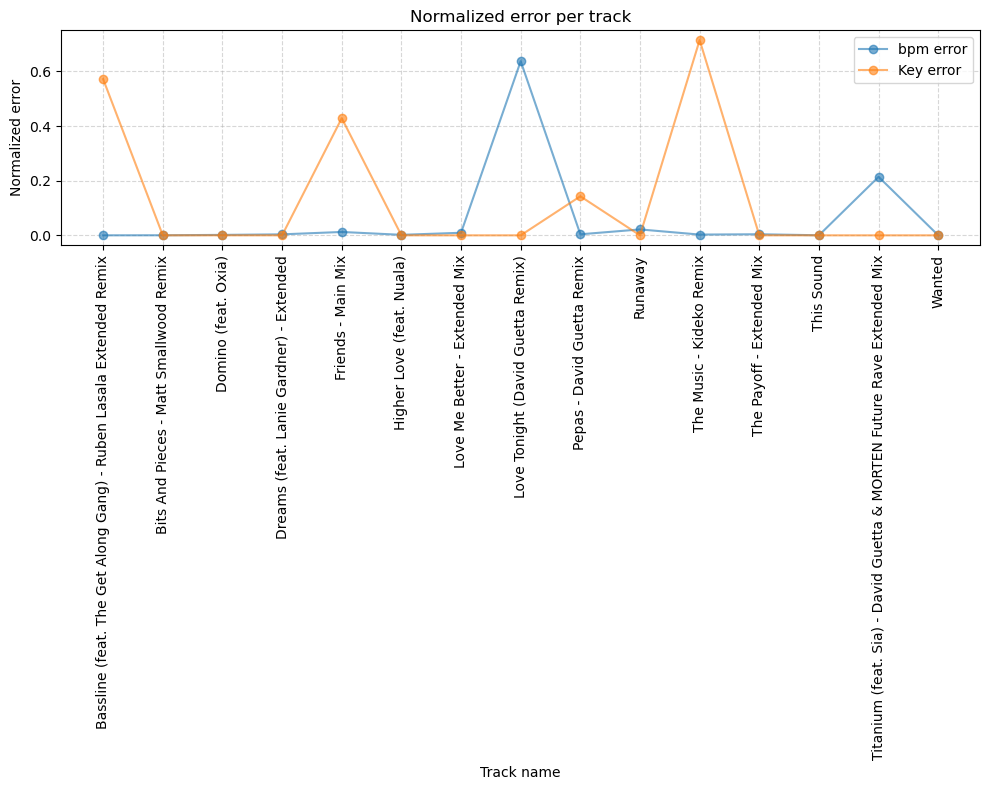

In [7]:
def plot_bpm_key_error(df):
    bpm_e = []
    key_e = []
    for i, row in df.iterrows():
        bpm_t = row["bpm"]; bpm_p = row["predicted_bpm"] 
        key_t = row["key"]; key_p = row["predicted_key"]
        bpm_e.append(bpm_diff(bpm_t, bpm_p))
        key_e.append(key_diff(key_t, key_p))

    df["bpm_dist"] = bpm_e
    df["key_dist"] = key_e

    # Plot average error per genre
    bpm_avg = df["bpm_dist"].mean()
    key_avg = df["key_dist"].mean()
    
    print(f"Average normalized bpm error: {bpm_avg}\nAverage normalized key error: {key_avg}")

    plt.figure(figsize=(8,5))
    plt.bar(['bpm error', 'key error'], [bpm_avg, key_avg], color=["tab:blue", "tab:orange"])
    plt.ylabel("Normalized error")
    plt.legend()
    plt.title("Average Normalized error")
    plt.tight_layout()
    plt.show()

    # Plot per-track error
    plt.figure(figsize=(10,8))
    plt.plot(df["bpm_dist"], alpha=0.6, label="bpm error", color="tab:blue", marker='o')
    plt.plot(df["key_dist"], alpha=0.6, label="Key error", color="tab:orange", marker='o')
    plt.xticks(range(len(df['name'])), df["name"], rotation=90)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.ylabel("Normalized error")
    plt.xlabel("Track name")
    plt.title("Normalized error per track")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
plot_bpm_key_error(df_extended)

Calculate optimized song order and compare with original order

In [8]:
df_prediction = df_extended[['name', 'predicted_bpm', 'predicted_key']]
df_reference = df_extended[['name', 'bpm', 'key', 'ix']]
df_prediction.columns = ['name', 'bpm', 'key']

ordered_perm, cost = create_path_from_df(df_prediction)
#print(ordered_perm)

df_ordered_p = df_prediction.iloc[ordered_perm]#.reset_index(drop=True)
#print(df_ordered_p.index.tolist())

# Ordering the reference set
df_ordered_r = df_reference.sort_values(by='ix')
reference_perm = df_ordered_r.index.tolist()



In [9]:
total_cost_p = cost
total_cost_r = sum([transition_cost(df_ordered_r.iloc[i], df_ordered_r.iloc[i+1], w_h=0.5, w_t=0.5) for i in range(len(df_ordered_r)-1)])
print("Total cost reference order:", total_cost_r)
print("Total cost optimized order:", total_cost_p)

print(reference_perm)
print(ordered_perm)

pd.concat([df_ordered_r['name'].reset_index(drop=True), 
           df_ordered_p['name'].reset_index(drop=True)], 
          axis=1).reset_index(drop=True).head(20)

Total cost reference order: 2.6604946819524153
Total cost optimized order: 2.1527416993616466
[13, 4, 7, 8, 3, 2, 6, 9, 10, 12, 14, 5, 0, 11, 1]
[0, 10, 4, 8, 5, 6, 3, 14, 12, 11, 13, 9, 7, 1, 2]


,name,name
0,Titanium (feat. Sia) - David Guetta & MORTEN F...,Bassline (feat. The Get Along Gang) - Ruben La...
1,Friends - Main Mix,The Music - Kideko Remix
2,Love Tonight (David Guetta Remix),Friends - Main Mix
3,Pepas - David Guetta Remix,Pepas - David Guetta Remix
4,Dreams (feat. Lanie Gardner) - Extended,Higher Love (feat. Nuala)
5,Domino (feat. Oxia),Love Me Better - Extended Mix
6,Love Me Better - Extended Mix,Dreams (feat. Lanie Gardner) - Extended
7,Runaway,Wanted
8,The Music - Kideko Remix,This Sound
9,This Sound,The Payoff - Extended Mix


In [10]:
from scipy.stats import kendalltau, spearmanr

corr_kendall, p_ken = kendalltau(ordered_perm, reference_perm)

corr_spearmanr, p_spear = spearmanr(ordered_perm, reference_perm)

print(f"Kendall Tau correlation: {round(corr_kendall*100, 3)}% p val {p_ken}")
print(f"Spearman correlation: {round(corr_spearmanr*100, 3)}% p val {p_spear}%")





Kendall Tau correlation: 14.286% p val 0.4950508526248027
Spearman correlation: 21.429% p val 0.44314093482351424%


In [11]:
df_prediction.head(20)

,name,bpm,key
0,Bassline (feat. The Get Along Gang) - Ruben La...,124.002596,3B
1,Bits And Pieces - Matt Smallwood Remix,128.011924,4A
2,Domino (feat. Oxia),126.072096,2A
3,Dreams (feat. Lanie Gardner) - Extended,128.160265,8A
4,Friends - Main Mix,126.540527,10A
5,Higher Love (feat. Nuala),125.080423,9A
6,Love Me Better - Extended Mix,124.404098,8A
7,Love Tonight (David Guetta Remix),157.130859,5A
8,Pepas - David Guetta Remix,127.168157,9A
9,Runaway,125.939941,5A


**EVEN SPLIT**

Kendall Tau correlation: 12.381% p val 0.5589660721223221
Spearman correlation: 18.929 p val 0.49926303323854526%

**Dubble imprtance key**

Kendall Tau correlation: 14.286% p val 0.4950508526248027
Spearman correlation: 21.429 p val 0.44314093482351424%

**Only KEY**

Kendall Tau correlation: 14.286% p val 0.4950508526248027
Spearman correlation: 21.429% p val 0.44314093482351424%


**DUBBLE importance Tempo**

Kendall Tau correlation: 12.381% p val 0.5589660721223221
Spearman correlation: 18.929% p val 0.49926303323854526%

**ONLY TEMPO**

Kendall Tau correlation: 14.286% p val 0.4950508526248027
Spearman correlation: 21.429% p val 0.44314093482351424%


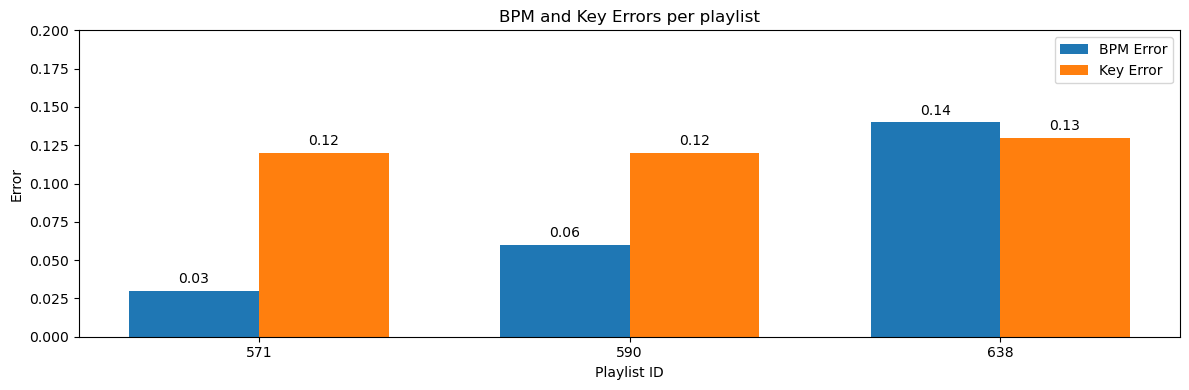

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Data
track_ids = ['571', '590', '638']
bpm_errors = [0.03, 0.06, 0.14]
key_errors = [0.12, 0.12, 0.13]

# Bar width and positions
x = np.arange(len(track_ids))
width = 0.35

# Create the bar plot
fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(x - width/2, bpm_errors, width, label='BPM Error')
ax.bar(x + width/2, key_errors, width, label='Key Error')

# Labels and formatting
ax.set_xlabel('Playlist ID')
ax.set_ylabel('Error')
ax.set_title('BPM and Key Errors per playlist')
ax.set_xticks(x)
ax.set_xticklabels(track_ids)
ax.legend()

# Add value labels on top of bars
for i in range(len(track_ids)):
    ax.text(x[i] - width/2, bpm_errors[i] + 0.005, f'{bpm_errors[i]:.2f}', ha='center')
    ax.text(x[i] + width/2, key_errors[i] + 0.005, f'{key_errors[i]:.2f}', ha='center')
plt.ylim(0,0.2)
plt.tight_layout()
plt.show()